# [주차 수요 예측](https://dacon.io/competitions/official/235745/overview/description)

# 1. 데이터 전처리

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns 
from matplotlib import rc 

plt.rcParams["axes.unicode_minus"] = False 
rc("font", family="Malgun Gothic")
# %matplotlib inline 
get_ipython().run_line_magic("matplotlib", "inline")

In [2]:
train = pd.read_csv('./parking_data/train.csv')
test = pd.read_csv('./parking_data/test.csv')
age_gender_info = pd.read_csv('./parking_data/age_gender_info.csv')

## 0) 오류 데이터 삭제

In [3]:
# 2,3번 데이터 - 삭제 요망
# 1번 데이터 - 모델 학습 후 삭제 여부 판단

# 2번 데이터 오류 
train = train[train['단지코드'] != 'C2085']
train = train[train['단지코드'] != 'C1397']
train = train[train['단지코드'] != 'C2431']
train = train[train['단지코드'] != 'C1649']
train = train[train['단지코드'] != 'C1036']

# 3번 데이터 오류 
train = train[train['단지코드'] != 'C1095']
train = train[train['단지코드'] != 'C2051']
train = train[train['단지코드'] != 'C1218']
train = train[train['단지코드'] != 'C1894']
train = train[train['단지코드'] != 'C2483']
train = train[train['단지코드'] != 'C1502']
train = train[train['단지코드'] != 'C1988']

## 1) 컬럼별 null값 확인

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2869 entries, 8 to 2951
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          2869 non-null   object 
 1   총세대수                          2869 non-null   int64  
 2   임대건물구분                        2869 non-null   object 
 3   지역                            2869 non-null   object 
 4   공급유형                          2869 non-null   object 
 5   전용면적                          2869 non-null   float64
 6   전용면적별세대수                      2869 non-null   int64  
 7   공가수                           2869 non-null   float64
 8   자격유형                          2869 non-null   object 
 9   임대보증금                         2300 non-null   object 
 10  임대료                           2300 non-null   object 
 11  도보 10분거리 내 지하철역 수(환승노선 수 반영)  2662 non-null   float64
 12  도보 10분거리 내 버스정류장 수            2869 non-null   float64
 13  단지내

In [5]:
train.isnull().sum()

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                           569
임대료                             569
도보 10분거리 내 지하철역 수(환승노선 수 반영)    207
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
등록차량수                             0
dtype: int64

--> train data null값 존재 컬럼: 임대보증금, 임대료, 도보 10분거리 내 지하철역 수

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022 entries, 0 to 1021
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          1022 non-null   object 
 1   총세대수                          1022 non-null   int64  
 2   임대건물구분                        1022 non-null   object 
 3   지역                            1022 non-null   object 
 4   공급유형                          1022 non-null   object 
 5   전용면적                          1022 non-null   float64
 6   전용면적별세대수                      1022 non-null   int64  
 7   공가수                           1022 non-null   float64
 8   자격유형                          1020 non-null   object 
 9   임대보증금                         842 non-null    object 
 10  임대료                           842 non-null    object 
 11  도보 10분거리 내 지하철역 수(환승노선 수 반영)  980 non-null    float64
 12  도보 10분거리 내 버스정류장 수            1022 non-null   float64
 13  단지내

In [7]:
test.isnull().sum()

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              2
임대보증금                           180
임대료                             180
도보 10분거리 내 지하철역 수(환승노선 수 반영)     42
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
dtype: int64

--> test data null값 존재 컬럼: 임대보증금, 임대료, 도보 10분 내 지하철역 수, 자격유형

## 1. 임대료, 임대보증금 컬럼
```
1) 데이터 타입 float로 변환
2) null값 --> train 데이터의 평균값 또는 0으로 대체
```

### 1) 데이터 타입 float로 변환

In [8]:
train.loc[train['임대보증금']=='-','임대보증금'] = np.nan
train.loc[train['임대료']=='-','임대료'] = np.nan

train['임대보증금'] = train['임대보증금'].astype(float)
train['임대료'] = train['임대료'].astype(float)

In [9]:
test.loc[test['임대보증금']=='-','임대보증금'] = np.nan
test.loc[test['임대료']=='-','임대료'] = np.nan

test['임대보증금'] = test['임대보증금'].astype(float)
test['임대료'] = test['임대료'].astype(float)

### 2) null값 --> train 데이터의 평균값 또는 0으로 대체
- 임대보증금 or 임대료가 null값이 데이터를 공급유형별, 지역별로 나누어서 살펴보기

#### 1. (Train data) 임대보증금/임대료의 null 값 - (공급유형-임대상가) 인 데이터부터 처리하기

In [10]:
train[train['임대보증금'].isnull()]['공급유형'].value_counts()

임대상가    562
국민임대      8
공공분양      7
행복주택      4
Name: 공급유형, dtype: int64

In [11]:
train[train['임대료'].isnull()]['공급유형'].value_counts()

임대상가    562
국민임대      8
공공분양      7
행복주택      4
장기전세      3
Name: 공급유형, dtype: int64

In [12]:
train['공급유형'].value_counts()

국민임대         1727
임대상가          562
행복주택          202
공공임대(10년)     175
영구임대          152
공공임대(50년)      31
공공임대(분납)        7
공공분양            7
장기전세            3
공공임대(5년)        3
Name: 공급유형, dtype: int64

- 전체 데이터 공급유형 컬럼:임대상가인 개수 - 562개인데, 임대보증금이 null값인 데이터에서 공급유형 컬럼: 임대상가인 경우 - 562개이다.

==> 공급유형이 임대상가인 데이터는 임대보증금이 모두 null값이다

--> null값은 지역별 평균값 or 0으로 대체(둘 중 모델 학습 성능 더 좋은 것으로 채택)

In [13]:
# 이 데이터는 전부 null값이다
train[train['공급유형']=='임대상가']['지역'].value_counts()

부산광역시      220
대전광역시      113
경상남도        97
충청남도        76
강원도         31
제주특별자치도     25
Name: 지역, dtype: int64

In [14]:
# 1. null -> 평균값
for col in train[train['공급유형']=='임대상가']['지역'].value_counts().index:
    train.loc[train['지역']==col,'임대료'] = train['임대료'].fillna( train[train['지역']==col]['임대료'].mean() )
    train.loc[train['지역']==col,'임대보증금'] = train['임대보증금'].fillna( train[train['지역']==col]['임대보증금'].mean() )
    
# 2. null -> 0

#### 2. (Train data) 나머지 null값 처리

In [15]:
train[train['임대보증금'].isnull()]['공급유형'].value_counts(), train[train['임대료'].isnull()]['공급유형'].value_counts()

(국민임대    3
 Name: 공급유형, dtype: int64,
 장기전세    3
 국민임대    3
 Name: 공급유형, dtype: int64)

In [16]:
train.loc[train['공급유형'] == '국민임대', '임대보증금'] = train['임대보증금'].fillna(0)
train.loc[train['공급유형'] == '국민임대', '임대료'] = train['임대료'].fillna(0)
train.loc[train['공급유형'] == '장기전세', '임대료'] = train['임대료'].fillna(0)

In [17]:
train[train['임대보증금'].isnull()]['공급유형'].value_counts(), train[train['임대료'].isnull()]['공급유형'].value_counts()

(Series([], Name: 공급유형, dtype: int64), Series([], Name: 공급유형, dtype: int64))

--> train data 임대보증금, 임대료 결측치 처리 완료

#### 3. (Test data) 임대보증금/임대료의 null 값 처리
- train 데이터와 마찬가지로, 공급유형=임대상가 인 데이터(177건)는 전부 임대보증금이 null값을 가진다

In [18]:
test[test['임대보증금'].isnull()]['공급유형'].value_counts()

임대상가    177
영구임대      5
행복주택      4
Name: 공급유형, dtype: int64

In [19]:
test[test['임대료'].isnull()]['공급유형'].value_counts()

임대상가    177
영구임대      5
행복주택      4
Name: 공급유형, dtype: int64

In [20]:
test['공급유형'].value_counts()

국민임대         622
임대상가         177
행복주택         124
영구임대          45
공공임대(10년)     35
공공임대(50년)     13
공공임대(분납)       6
Name: 공급유형, dtype: int64

In [21]:
test[test['공급유형']=='임대상가']['지역'].value_counts()

울산광역시    47
강원도      45
부산광역시    43
충청남도     22
대전광역시    20
Name: 지역, dtype: int64

In [22]:
# 1. test 데이터의 임대료/임대보증금 null값 -> train의 지역별 임대료/임대보증금 평균값으로 대체
for col in test[test['공급유형']=='임대상가']['지역'].value_counts().index:
    test.loc[test['지역']==col,'임대료'] = test['임대료'].fillna( train[train['지역']==col]['임대료'].mean() )
    test.loc[test['지역']==col,'임대보증금'] = test['임대보증금'].fillna( train[train['지역']==col]['임대보증금'].mean() )
    

#### 4. (Test data) 나머지 null값 처리

In [23]:
test[test['임대보증금'].isnull()]['공급유형'].value_counts(), test[test['임대료'].isnull()]['공급유형'].value_counts()

(행복주택    4
 Name: 공급유형, dtype: int64,
 행복주택    4
 Name: 공급유형, dtype: int64)

In [24]:
test['임대보증금'] = test['임대보증금'].fillna(0)
test['임대료'] = test['임대료'].fillna(0)

In [25]:
test['임대보증금'].isnull().sum(), test['임대료'].isnull().sum()

(0, 0)

--> test data 임대보증금, 임대료 결측치 처리 완료

## 2. 도보 10분거리 내 지하철역 수, 버스정류장 수

### 1) 지하철역 수
- train, test 데이터에 모두 null값이 존재
- 전체 데이터의 분포는 0이 상당수를 차지하고 있음
=> null값 0으로 대체

In [26]:
train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].isnull().sum(), test['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].isnull().sum()

(207, 42)

In [27]:
train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].value_counts(), test['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].value_counts()

(0.0    2223
 1.0     400
 2.0      33
 3.0       6
 Name: 도보 10분거리 내 지하철역 수(환승노선 수 반영), dtype: int64,
 0.0    881
 1.0     64
 2.0     35
 Name: 도보 10분거리 내 지하철역 수(환승노선 수 반영), dtype: int64)

--> 대부분이 0이므로 null값 0으로 대체

In [28]:
train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'] = train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].fillna(0)
test['도보 10분거리 내 지하철역 수(환승노선 수 반영)'] = test['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].fillna(0)

train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].isnull().sum(), test['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].isnull().sum()

(0, 0)

--> train, test data의 지하철역 수 결측치 처리 완료

### 2) 버스정류장 수
- null값 존재하지 않음
- 데이터 분포 확인 -> test 데이터에 outlier 존재 (10분 내 거리에 버스정류장 수: 50개)

In [29]:
train['도보 10분거리 내 버스정류장 수'].isnull().sum(), test['도보 10분거리 내 버스정류장 수'].isnull().sum()

(0, 0)

In [30]:
train['도보 10분거리 내 버스정류장 수'].unique(), test['도보 10분거리 내 버스정류장 수'].unique()

(array([ 3.,  1.,  2.,  6., 10.,  5.,  4.,  7., 12., 14.,  8.,  0., 20.,
        11., 16., 15., 19.]),
 array([ 2.,  3., 16.,  6.,  1.,  4.,  5.,  8., 10., 13.,  7., 11., 50.,
        12., 14., 18., 15., 19., 17.]))

In [31]:
train['도보 10분거리 내 버스정류장 수'].value_counts()

2.0     774
3.0     716
4.0     485
1.0     270
5.0     162
6.0     153
8.0      99
10.0     80
7.0      65
12.0     22
20.0     15
15.0     11
16.0      6
19.0      4
11.0      3
14.0      2
0.0       2
Name: 도보 10분거리 내 버스정류장 수, dtype: int64

In [32]:
test['도보 10분거리 내 버스정류장 수'].value_counts()

2.0     252
3.0     166
4.0     134
1.0     117
5.0     112
6.0      85
7.0      48
8.0      33
16.0     13
11.0     11
15.0     10
50.0      9
18.0      7
14.0      6
12.0      5
17.0      4
10.0      4
19.0      3
13.0      3
Name: 도보 10분거리 내 버스정류장 수, dtype: int64

In [33]:
test[test['도보 10분거리 내 버스정류장 수']==50]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
383,C1852,898,아파트,경기도,국민임대,39.59,219,6.0,H,23720000.0,197230.0,0.0,50.0,785.0
384,C1852,898,아파트,경기도,국민임대,39.72,56,6.0,A,23720000.0,197230.0,0.0,50.0,785.0
385,C1852,898,아파트,경기도,국민임대,39.72,44,6.0,A,23720000.0,197230.0,0.0,50.0,785.0
386,C1852,898,아파트,경기도,국민임대,46.90,46,6.0,A,37454000.0,259660.0,0.0,50.0,785.0
387,C1852,898,아파트,경기도,국민임대,46.90,22,6.0,A,37454000.0,259660.0,0.0,50.0,785.0
388,C1852,898,아파트,경기도,국민임대,46.90,225,6.0,H,37454000.0,259660.0,0.0,50.0,785.0
389,C1852,898,아파트,경기도,국민임대,51.93,136,6.0,H,45193000.0,308350.0,0.0,50.0,785.0
390,C1852,898,아파트,경기도,국민임대,51.93,44,6.0,H,45193000.0,308350.0,0.0,50.0,785.0
391,C1852,898,아파트,경기도,국민임대,59.61,106,6.0,H,61674000.0,370790.0,0.0,50.0,785.0


--> 버스정류장 수가 50인 경우, train 데이터의 평균값 or 최댓값으로 변환하여 처리

*평균값 vs 최댓값 둘 다 모델 돌려봐야 알 것 같다**

In [34]:
# test 의 평균값으로 채우면 안됨 -> data leakage 발생(test의 통계치는 활용하면 안됨, 모르는 값이기 때문에)
test.loc[test['도보 10분거리 내 버스정류장 수']==50, '도보 10분거리 내 버스정류장 수'] = train['도보 10분거리 내 버스정류장 수'].mean()

In [35]:
train['도보 10분거리 내 버스정류장 수'].mean(), train['도보 10분거리 내 버스정류장 수'].max()

(3.709654932032067, 20.0)

In [36]:
test[test['도보 10분거리 내 버스정류장 수']==50]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수


--> test data 버스정류장 수 이상치 처리 완료

## 3. 자격유형 (test 데이터 결측치)
- test data의 자격유형 결측치는 총 2개
- 동일 단지코드, 공급유형을 가진 데이터의 자격유형을 살펴본다

In [37]:
test[test['자격유형'].isnull()]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
196,C2411,962,아파트,경상남도,국민임대,46.90,240,25.0,NaN,71950000.0,37470.0,0.0,2.0,840.0
258,C2253,1161,아파트,강원도,영구임대,26.37,745,0.0,NaN,2249000.0,44770.0,0.0,2.0,173.0


#### 1. 첫 번쨰 결측치: 단지코드 C2411

In [38]:
test[test['단지코드']=='C2411']

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
193,C2411,962,아파트,경상남도,국민임대,39.43,56,25.0,A,11992000.0,100720.0,0.0,2.0,840.0
194,C2411,962,아파트,경상남도,국민임대,39.72,336,25.0,A,11992000.0,100720.0,0.0,2.0,840.0
195,C2411,962,아파트,경상남도,국민임대,39.82,179,25.0,A,11992000.0,100720.0,0.0,2.0,840.0
196,C2411,962,아파트,경상남도,국민임대,46.90,240,25.0,NaN,71950000.0,37470.0,0.0,2.0,840.0
197,C2411,962,아파트,경상남도,국민임대,51.93,150,25.0,A,21586000.0,171480.0,0.0,2.0,840.0


--> 동일 단지코드의 다른 자격유형은 모두 A이므로 null값을 A로 채운다

In [39]:
test.loc[(test['단지코드']=='C2411') & test['자격유형'].isnull(),'자격유형']

196    NaN
Name: 자격유형, dtype: object

In [40]:
test.loc[(test['단지코드']=='C2411') & test['자격유형'].isnull(),'자격유형'] = 'A'
test.loc[test['단지코드']=='C2411','자격유형']

193    A
194    A
195    A
196    A
197    A
Name: 자격유형, dtype: object

#### 2. 두 번째 결측치: 단지코드 C2253

In [41]:
test[(test['단지코드']=='C2253') & (test['공급유형']=='영구임대')]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
258,C2253,1161,아파트,강원도,영구임대,26.37,745,0.0,NaN,2249000.0,44770.0,0.0,2.0,173.0
259,C2253,1161,아파트,강원도,영구임대,31.32,239,0.0,C,3731000.0,83020.0,0.0,2.0,173.0
260,C2253,1161,아파트,강원도,영구임대,31.32,149,0.0,C,3731000.0,83020.0,0.0,2.0,173.0


--> 동일 단지코드, 공급유형의 자격유형이 모두 C이므로 C로 채운다

In [42]:
test.loc[(test['자격유형'].isnull()) & (test['단지코드']=='C2253'),'자격유형']

258    NaN
Name: 자격유형, dtype: object

In [43]:
test.loc[(test['자격유형'].isnull()) & (test['단지코드']=='C2253'),'자격유형'] = 'C'
test.loc[(test['단지코드']=='C2253') & (test['공급유형']=='영구임대'),'자격유형']

258    C
259    C
260    C
Name: 자격유형, dtype: object

In [44]:
test['자격유형'].isnull().sum()

0

--> test data의 자격유형 결측치 처리 완료

---

In [45]:
train.isnull().sum()

단지코드                            0
총세대수                            0
임대건물구분                          0
지역                              0
공급유형                            0
전용면적                            0
전용면적별세대수                        0
공가수                             0
자격유형                            0
임대보증금                           0
임대료                             0
도보 10분거리 내 지하철역 수(환승노선 수 반영)    0
도보 10분거리 내 버스정류장 수              0
단지내주차면수                         0
등록차량수                           0
dtype: int64

In [46]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2869 entries, 8 to 2951
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          2869 non-null   object 
 1   총세대수                          2869 non-null   int64  
 2   임대건물구분                        2869 non-null   object 
 3   지역                            2869 non-null   object 
 4   공급유형                          2869 non-null   object 
 5   전용면적                          2869 non-null   float64
 6   전용면적별세대수                      2869 non-null   int64  
 7   공가수                           2869 non-null   float64
 8   자격유형                          2869 non-null   object 
 9   임대보증금                         2869 non-null   float64
 10  임대료                           2869 non-null   float64
 11  도보 10분거리 내 지하철역 수(환승노선 수 반영)  2869 non-null   float64
 12  도보 10분거리 내 버스정류장 수            2869 non-null   float64
 13  단지내

In [47]:
train.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
8,C2515,545,아파트,경상남도,국민임대,33.48,276,17.0,A,9216000.0,82940.0,0.0,3.0,624.0,205.0
9,C2515,545,아파트,경상남도,국민임대,39.60,60,17.0,A,12672000.0,107130.0,0.0,3.0,624.0,205.0
10,C2515,545,아파트,경상남도,국민임대,39.60,20,17.0,A,12672000.0,107130.0,0.0,3.0,624.0,205.0
11,C2515,545,아파트,경상남도,국민임대,46.90,38,17.0,A,18433000.0,149760.0,0.0,3.0,624.0,205.0
12,C2515,545,아파트,경상남도,국민임대,46.90,19,17.0,A,18433000.0,149760.0,0.0,3.0,624.0,205.0


In [48]:
test.isnull().sum()

단지코드                            0
총세대수                            0
임대건물구분                          0
지역                              0
공급유형                            0
전용면적                            0
전용면적별세대수                        0
공가수                             0
자격유형                            0
임대보증금                           0
임대료                             0
도보 10분거리 내 지하철역 수(환승노선 수 반영)    0
도보 10분거리 내 버스정류장 수              0
단지내주차면수                         0
dtype: int64

In [49]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022 entries, 0 to 1021
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          1022 non-null   object 
 1   총세대수                          1022 non-null   int64  
 2   임대건물구분                        1022 non-null   object 
 3   지역                            1022 non-null   object 
 4   공급유형                          1022 non-null   object 
 5   전용면적                          1022 non-null   float64
 6   전용면적별세대수                      1022 non-null   int64  
 7   공가수                           1022 non-null   float64
 8   자격유형                          1022 non-null   object 
 9   임대보증금                         1022 non-null   float64
 10  임대료                           1022 non-null   float64
 11  도보 10분거리 내 지하철역 수(환승노선 수 반영)  1022 non-null   float64
 12  도보 10분거리 내 버스정류장 수            1022 non-null   float64
 13  단지내

In [50]:
test.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
0,C1072,754,아파트,경기도,국민임대,39.79,116,14.0,H,22830000.0,189840.0,0.0,2.0,683.0
1,C1072,754,아파트,경기도,국민임대,46.81,30,14.0,A,36048000.0,249930.0,0.0,2.0,683.0
2,C1072,754,아파트,경기도,국민임대,46.90,112,14.0,H,36048000.0,249930.0,0.0,2.0,683.0
3,C1072,754,아파트,경기도,국민임대,46.90,120,14.0,H,36048000.0,249930.0,0.0,2.0,683.0
4,C1072,754,아파트,경기도,국민임대,51.46,60,14.0,H,43497000.0,296780.0,0.0,2.0,683.0


--> train, test 데이터의 이상치, 결측치 모두 처리 완료

## 2) age 데이터 정리
- 20세 미만(미성년자) 데이터는 '지역' 컬럼 기준으로 train 데이터와 병합

In [51]:
age_gender_info.head()

,지역,10대미만(여자),10대미만(남자),10대(여자),10대(남자),20대(여자),20대(남자),30대(여자),30대(남자),40대(여자),...,60대(여자),60대(남자),70대(여자),70대(남자),80대(여자),80대(남자),90대(여자),90대(남자),100대(여자),100대(남자)
0,경상북도,0.030158,0.033195,0.056346,0.061360,0.060096,0.067859,0.053433,0.049572,0.083660,...,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014
1,경상남도,0.027400,0.026902,0.053257,0.055568,0.064920,0.070618,0.056414,0.057550,0.077092,...,0.087201,0.069562,0.048357,0.033277,0.027361,0.011295,0.004910,0.001086,0.000179,0.000010
2,대전광역시,0.028197,0.029092,0.040490,0.042793,0.060834,0.064247,0.068654,0.066848,0.074667,...,0.088468,0.070261,0.051010,0.037143,0.032455,0.013751,0.006494,0.001740,0.000298,0.000066
3,경기도,0.038030,0.039507,0.052546,0.053990,0.058484,0.059894,0.072331,0.068704,0.083208,...,0.074237,0.058419,0.042422,0.032725,0.025136,0.012354,0.005390,0.001707,0.000290,0.000067
4,전라북도,0.028089,0.029065,0.059685,0.060080,0.066262,0.070322,0.052027,0.046596,0.077005,...,0.076636,0.068042,0.051025,0.035748,0.035049,0.012641,0.007223,0.001898,0.000158,0.000013


In [52]:
under_20 = ['10대미만(여자)', '10대미만(남자)', '10대(여자)', '10대(남자)']
age_gender_info['미성년자 비율'] = age_gender_info[under_20].sum(axis=1)
age_gender_info.head()

,지역,10대미만(여자),10대미만(남자),10대(여자),10대(남자),20대(여자),20대(남자),30대(여자),30대(남자),40대(여자),...,60대(남자),70대(여자),70대(남자),80대(여자),80대(남자),90대(여자),90대(남자),100대(여자),100대(남자),미성년자 비율
0,경상북도,0.030158,0.033195,0.056346,0.061360,0.060096,0.067859,0.053433,0.049572,0.083660,...,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014,0.181059
1,경상남도,0.027400,0.026902,0.053257,0.055568,0.064920,0.070618,0.056414,0.057550,0.077092,...,0.069562,0.048357,0.033277,0.027361,0.011295,0.004910,0.001086,0.000179,0.000010,0.163127
2,대전광역시,0.028197,0.029092,0.040490,0.042793,0.060834,0.064247,0.068654,0.066848,0.074667,...,0.070261,0.051010,0.037143,0.032455,0.013751,0.006494,0.001740,0.000298,0.000066,0.140571
3,경기도,0.038030,0.039507,0.052546,0.053990,0.058484,0.059894,0.072331,0.068704,0.083208,...,0.058419,0.042422,0.032725,0.025136,0.012354,0.005390,0.001707,0.000290,0.000067,0.184072
4,전라북도,0.028089,0.029065,0.059685,0.060080,0.066262,0.070322,0.052027,0.046596,0.077005,...,0.068042,0.051025,0.035748,0.035049,0.012641,0.007223,0.001898,0.000158,0.000013,0.176920


In [53]:
train

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
8,C2515,545,아파트,경상남도,국민임대,33.48,276,17.0,A,9216000.0,82940.0,0.0,3.0,624.0,205.0
9,C2515,545,아파트,경상남도,국민임대,39.60,60,17.0,A,12672000.0,107130.0,0.0,3.0,624.0,205.0
10,C2515,545,아파트,경상남도,국민임대,39.60,20,17.0,A,12672000.0,107130.0,0.0,3.0,624.0,205.0
11,C2515,545,아파트,경상남도,국민임대,46.90,38,17.0,A,18433000.0,149760.0,0.0,3.0,624.0,205.0
12,C2515,545,아파트,경상남도,국민임대,46.90,19,17.0,A,18433000.0,149760.0,0.0,3.0,624.0,205.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2947,C2532,239,아파트,강원도,국민임대,49.20,19,7.0,A,11346000.0,116090.0,0.0,1.0,166.0,146.0
2948,C2532,239,아파트,강원도,국민임대,51.08,34,7.0,A,14005000.0,142310.0,0.0,1.0,166.0,146.0
2949,C2532,239,아파트,강원도,국민임대,51.73,34,7.0,A,14005000.0,142310.0,0.0,1.0,166.0,146.0
2950,C2532,239,아파트,강원도,국민임대,51.96,114,7.0,A,14005000.0,142310.0,0.0,1.0,166.0,146.0


In [54]:
train = train.merge(age_gender_info[['지역','미성년자 비율']],on='지역')
test = test.merge(age_gender_info[['지역','미성년자 비율']],on='지역')
train

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,미성년자 비율
0,C2515,545,아파트,경상남도,국민임대,33.48,276,17.0,A,9216000.0,82940.0,0.0,3.0,624.0,205.0,0.163127
1,C2515,545,아파트,경상남도,국민임대,39.60,60,17.0,A,12672000.0,107130.0,0.0,3.0,624.0,205.0,0.163127
2,C2515,545,아파트,경상남도,국민임대,39.60,20,17.0,A,12672000.0,107130.0,0.0,3.0,624.0,205.0,0.163127
3,C2515,545,아파트,경상남도,국민임대,46.90,38,17.0,A,18433000.0,149760.0,0.0,3.0,624.0,205.0,0.163127
4,C2515,545,아파트,경상남도,국민임대,46.90,19,17.0,A,18433000.0,149760.0,0.0,3.0,624.0,205.0,0.163127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2864,C2086,1080,아파트,세종특별자치시,공공임대(10년),59.94,30,7.0,A,39000000.0,460000.0,0.0,2.0,1142.0,1524.0,0.176979
2865,C2086,1080,아파트,세종특별자치시,공공임대(10년),74.92,156,7.0,A,49000000.0,550000.0,0.0,2.0,1142.0,1524.0,0.176979
2866,C2086,1080,아파트,세종특별자치시,공공임대(10년),74.93,78,7.0,A,49000000.0,550000.0,0.0,2.0,1142.0,1524.0,0.176979
2867,C2086,1080,아파트,세종특별자치시,공공임대(10년),84.88,160,7.0,A,61000000.0,600000.0,0.0,2.0,1142.0,1524.0,0.176979


---

# 2. EDA
```
1) 중복값 확인
2) '공급유형', '자격유형' 컬럼 병합
3) '단지 코드' 기준 데이터 병합
```

In [55]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2869 entries, 0 to 2868
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          2869 non-null   object 
 1   총세대수                          2869 non-null   int64  
 2   임대건물구분                        2869 non-null   object 
 3   지역                            2869 non-null   object 
 4   공급유형                          2869 non-null   object 
 5   전용면적                          2869 non-null   float64
 6   전용면적별세대수                      2869 non-null   int64  
 7   공가수                           2869 non-null   float64
 8   자격유형                          2869 non-null   object 
 9   임대보증금                         2869 non-null   float64
 10  임대료                           2869 non-null   float64
 11  도보 10분거리 내 지하철역 수(환승노선 수 반영)  2869 non-null   float64
 12  도보 10분거리 내 버스정류장 수            2869 non-null   float64
 13  단지내

## 1) 중복값 확인
- 중복값 제거

In [56]:
train.shape, train.drop_duplicates().shape

((2869, 16), (2549, 16))

In [57]:
test.shape, test.drop_duplicates().shape

((1022, 15), (949, 15))

In [58]:
train = train.drop_duplicates()
test = test.drop_duplicates()

## 2) '공급유형', '자격유형' 컬럼 병합

In [59]:
col_category = ['단지코드', '임대건물구분', '지역', '공급유형','자격유형']

In [60]:
# 범주형 변수의 데이터 분포도 그리는 함수

def cnt_bar(col):
    cnt_df = train[col].value_counts()
    plt.figure(figsize=(5,5))
    plt.bar(cnt_df.index, cnt_df)
    plt.xticks(rotation=90)
    plt.title(col)

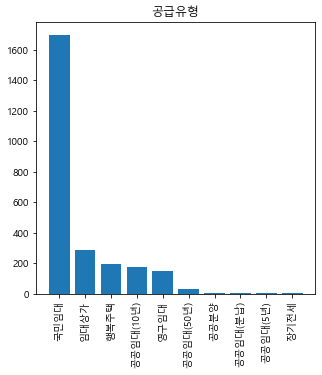

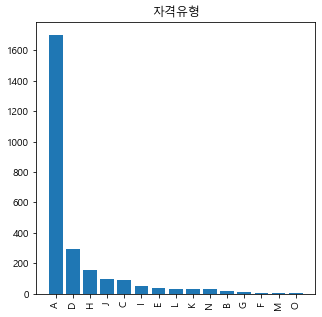

In [61]:
cnt_bar('공급유형'), cnt_bar('자격유형');

In [62]:
train.pivot_table(index=['공급유형','자격유형'])

공가수      단지내주차면수  도보 10분거리 내 버스정류장 수  \
공급유형      자격유형                                               
공공분양      D      2.000000  1636.000000            6.000000   
공공임대(10년) A     10.248555   943.653179            3.710983   
공공임대(50년) A      2.419355   303.258065            4.903226   
공공임대(5년)  A      1.000000   772.000000            2.000000   
공공임대(분납)  A      0.857143   968.000000            4.285714   
국민임대      A     13.605121   645.996631            3.722372   
          B     13.666667   599.166667            2.000000   
          E     29.147059   822.823529            6.323529   
          G     14.333333  1208.444444            2.888889   
          H     16.506494   961.090909            3.824675   
영구임대      A      4.000000   880.000000            4.000000   
          C      7.717391   248.097826            4.184783   
          E      3.666667   348.000000            2.000000   
          F      1.000000   756.000000            1.000000   
          I     10.816327   804.469388            3.122449   
임대상가      D      6.477193   287.575439            3.421053   
장기전세      A     13.000000   673.000000            3.000000   
행복주택      J     25.074468   442.223404            3.606383   
          K     36.696970   489.787879            2.272727   
          L     12.090909   320.636364            3.666667   
          M     32.000000   635.000000            2.000000   
          N     27.034483   934.448276            3.241379   
          O     32.000000   635.000000            2.000000   

                도보 10분거리 내 지하철역 수(환승노선 수 반영)        등록차량수   미성년자 비율  \
공급유형      자격유형                                                        
공공분양      D                         0.000000  2315.000000  0.140571   
공공임대(10년) A                         0.086705  1204.838150  0.160263   
공공임대(50년) A                         0.064516   314.161290  0.167425   
공공임대(5년)  A                         1.000000   887.000000  0.140571   
공공임대(분납)  A                         0.000000  1283.000000  0.107262   
국민임대      A                         0.139488   609.077493  0.170440   
          B                         0.277778   558.277778  0.157611   
          E                         0.029412   703.264706  0.175367   
          G                         0.111111   748.555556  0.176191   
          H                         0.077922   914.428571  0.177443   
영구임대      A                         0.000000   763.000000  0.184072   
          C                         0.260870   173.586957  0.148971   
          E                         0.000000   245.333333  0.169910   
          F                         0.000000   359.000000  0.113143   
          I                         0.326531   777.346939  0.164301   
임대상가      D                         0.312281   166.712281  0.140272   
장기전세      A                         0.000000   645.000000  0.082280   
행복주택      J                         0.117021   296.191489  0.161611   
          K                         0.000000   332.060606  0.174316   
          L                         0.181818   277.545455  0.170269   
          M                         0.000000   416.000000  0.166665   
          N                         0.000000   683.862069  0.180060   
          O                         0.000000   416.000000  0.166665   

                          임대료         임대보증금       전용면적    전용면적별세대수  \
공급유형      자격유형                                                       
공공분양      D     173557.808219  2.355958e+07  80.661429  101.571429   
공공임대(10년) A     516312.601156  5.037727e+07  70.214971  131.601156   
공공임대(50년) A     201579.677419  1.395458e+07  43.898387  196.580645   
공공임대(5년)  A     400000.000000  2.700000e+07  48.886667  135.333333   
공공임대(분납)  A     263968.571429  1.055110e+08  71.671429   81.428571   
국민임대      A     170085.505391  2.148463e+07  45.022237  117.650270   
          B     137213.888889  1.676483e+07  44.164444   96.388889   
          E      49855.294118  9.572897e+07  46.074706  154.52941

--> 공급유형, 자격유형은 관련이 있는 것처럼 보인다.
- 공급유형, 자격유형을 인덱스로 train 데이터를 살펴보면, 공급유형에 전체 자격유형이 아니라 특정 자격유형만 포함되는 것을 볼 수 있다.

==>  공급유형, 자격유형 컬럼 합치고 기존 컬럼 삭제

In [63]:
(train['공급유형'] +'_'+ train['자격유형']).unique()

array(['국민임대_A', '영구임대_C', '임대상가_D', '공공임대(50년)_A', '국민임대_E',
       '공공임대(10년)_A', '국민임대_H', '영구임대_I', '행복주택_L', '행복주택_K', '영구임대_E',
       '공공분양_D', '공공임대(분납)_A', '공공임대(5년)_A', '행복주택_J', '국민임대_B', '국민임대_G',
       '영구임대_A', '행복주택_N', '행복주택_M', '행복주택_O', '영구임대_F', '장기전세_A'],
      dtype=object)

In [64]:
train['공급_자격유형'] = train['공급유형'] +'_'+ train['자격유형']
# train.drop(['공급유형','자격유형'],axis=1, inplace=True)
train.head()

C:\Users\tladu\AppData\Local\Temp/ipykernel_468/1022526846.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['공급_자격유형'] = train['공급유형'] +'_'+ train['자격유형']


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,미성년자 비율,공급_자격유형
0,C2515,545,아파트,경상남도,국민임대,33.48,276,17.0,A,9216000.0,82940.0,0.0,3.0,624.0,205.0,0.163127,국민임대_A
1,C2515,545,아파트,경상남도,국민임대,39.60,60,17.0,A,12672000.0,107130.0,0.0,3.0,624.0,205.0,0.163127,국민임대_A
2,C2515,545,아파트,경상남도,국민임대,39.60,20,17.0,A,12672000.0,107130.0,0.0,3.0,624.0,205.0,0.163127,국민임대_A
3,C2515,545,아파트,경상남도,국민임대,46.90,38,17.0,A,18433000.0,149760.0,0.0,3.0,624.0,205.0,0.163127,국민임대_A
4,C2515,545,아파트,경상남도,국민임대,46.90,19,17.0,A,18433000.0,149760.0,0.0,3.0,624.0,205.0,0.163127,국민임대_A


In [65]:
test['공급_자격유형'] = test['공급유형'] +'_'+ test['자격유형']
# train.drop(['공급유형','자격유형'],axis=1, inplace=True)
test.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,미성년자 비율,공급_자격유형
0,C1072,754,아파트,경기도,국민임대,39.79,116,14.0,H,22830000.0,189840.0,0.0,2.0,683.0,0.184072,국민임대_H
1,C1072,754,아파트,경기도,국민임대,46.81,30,14.0,A,36048000.0,249930.0,0.0,2.0,683.0,0.184072,국민임대_A
2,C1072,754,아파트,경기도,국민임대,46.90,112,14.0,H,36048000.0,249930.0,0.0,2.0,683.0,0.184072,국민임대_H
3,C1072,754,아파트,경기도,국민임대,46.90,120,14.0,H,36048000.0,249930.0,0.0,2.0,683.0,0.184072,국민임대_H
4,C1072,754,아파트,경기도,국민임대,51.46,60,14.0,H,43497000.0,296780.0,0.0,2.0,683.0,0.184072,국민임대_H


## 3) '단지 코드' 기준 데이터 병합
최종 예측값이 단지코드에 대한 주차 수요값이므로, 단지코드가 unique 값을 가지도록 단지코드를 기준으로 데이터프레임을 재구성해야 한다.

- 단지 코드로 분류했을 때, 다른 컬럼의 unique한 값의 개수를 센다
- 단지코드와 1:1 매칭이 되는지, 하나의 단지코드에 여러 개의 값을 가지고 있는지 확인

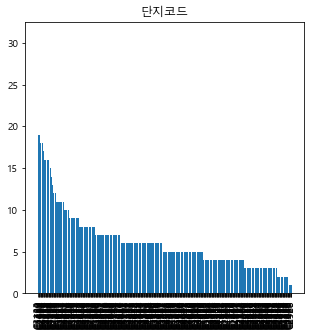

In [66]:
cnt_bar('단지코드')

In [67]:
train.pivot_table(index='단지코드',aggfunc='nunique')

,공가수,공급_자격유형,공급유형,단지내주차면수,도보 10분거리 내 버스정류장 수,도보 10분거리 내 지하철역 수(환승노선 수 반영),등록차량수,미성년자 비율,임대건물구분,임대료,임대보증금,자격유형,전용면적,전용면적별세대수,지역,총세대수
단지코드,,,,,,,,,,,,,,,,
C1000,1,1,1,1,1,1,1,1,1,3,3,1,5,6,1,1
C1004,1,2,2,1,1,1,1,1,2,3,3,2,15,3,1,1
C1005,1,1,1,1,1,1,1,1,1,3,3,1,3,3,1,1
C1013,1,1,1,1,1,1,1,1,1,3,3,1,4,5,1,1
C1014,1,1,1,1,1,1,1,1,1,4,4,1,6,7,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C2663,1,1,1,1,1,1,1,1,1,4,4,1,5,6,1,1
C2666,1,1,1,1,1,1,1,1,1,2,2,1,4,6,1,1
C2670,1,1,1,1,1,1,1,1,1,3,3,1,4,3,1,1


In [68]:
train.pivot_table(index='단지코드',aggfunc='nunique').sum()

공가수                              411
공급_자격유형                          502
공급유형                             475
단지내주차면수                          411
도보 10분거리 내 버스정류장 수               411
도보 10분거리 내 지하철역 수(환승노선 수 반영)     411
등록차량수                            411
미성년자 비율                          411
임대건물구분                           444
임대료                             1248
임대보증금                           1234
자격유형                             498
전용면적                            1835
전용면적별세대수                        2155
지역                               411
총세대수                             411
dtype: int64

```
- 하나의 단지코드에 대해 둘 이상의 항목이 존재하는 컬럼 (변형 필요):
'공급_자격유형'('공급유형', '자격유형'), '임대건물구분', '임대료', '임대보증금', '전용면적', '전용면적별세대수'

- 하나의 단지코드에 대해 하나의 항목만이 존재하는 컬럼 (그대로 사용 가능): // 변수명: unique_cols
'공가수', '단지내주차면수', '도보 10분거리 내 버스정류장 수', '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '미성년자 비율', '지역', '총세대수', '등록차량수'
```

### 1. 단지코드와 1:1 매칭 가능한 컬럼(unique_cols)
- 단지코드를 인덱스로 설정하여 unique_cols 값을 컬럼값으로 설정하고, 중복 삭제하여 unique한 단지 코드 값을 가지는 새로운 데이터프레임 만들기

- '공가수', '단지내주차면수', '도보 10분거리 내 버스정류장 수', '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '미성년자 비율', '지역', '총세대수', '등록차량수'

In [69]:
unique_cols = ['공가수', '단지내주차면수', '도보 10분거리 내 버스정류장 수',
               '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '미성년자 비율', '지역', '총세대수'] # 등록차량수 추가 필요

train_agg = train.set_index('단지코드')[unique_cols+['등록차량수']].drop_duplicates() # pivot table 사용하면 범주형 변수 반영 안됨
train_agg

,공가수,단지내주차면수,도보 10분거리 내 버스정류장 수,도보 10분거리 내 지하철역 수(환승노선 수 반영),미성년자 비율,지역,총세대수,등록차량수
단지코드,,,,,,,,
C2515,17.0,624.0,3.0,0.0,0.163127,경상남도,545,205.0
C2576,19.0,296.0,4.0,0.0,0.163127,경상남도,405,73.0
C2416,0.0,154.0,5.0,0.0,0.163127,경상남도,560,63.0
C2013,3.0,509.0,3.0,0.0,0.163127,경상남도,595,91.0
C1850,0.0,226.0,4.0,0.0,0.163127,경상남도,388,254.0
...,...,...,...,...,...,...,...,...
C1024,2.0,877.0,3.0,0.0,0.082280,서울특별시,680,957.0
C1652,20.0,423.0,8.0,1.0,0.082280,서울특별시,890,509.0
C2612,27.0,1689.0,2.0,0.0,0.176979,세종특별자치시,1684,1832.0


- test 데이터에서, 동일 단지코드 내에서의 통계치 반영은 data leakage가 아니다
- 같은 단지코드의 데이터는 단지 1개의 데이터로 해당 단지의 주차 수요를 예측하기위해 결합하는 것은 data leakage가 아님

In [70]:
test_agg = test.set_index('단지코드')[unique_cols].drop_duplicates() 
test_agg

,공가수,단지내주차면수,도보 10분거리 내 버스정류장 수,도보 10분거리 내 지하철역 수(환승노선 수 반영),미성년자 비율,지역,총세대수
단지코드,,,,,,,
C1072,14.0,683.0,2.0,0.0,0.184072,경기도,754
C1128,9.0,1216.0,3.0,0.0,0.184072,경기도,1354
C1332,11.0,1112.0,2.0,0.0,0.184072,경기도,1297
C1563,15.0,1696.0,6.0,0.0,0.184072,경기도,1974
C1721,20.0,573.0,3.0,0.0,0.184072,경기도,663
...,...,...,...,...,...,...,...
C1633,22.0,168.0,4.0,0.0,0.121385,대구광역시,178
C2451,2.0,433.0,3.0,0.0,0.121385,대구광역시,395
C2292,22.0,906.0,2.0,0.0,0.176979,세종특별자치시,906


#### 지역 컬럼 - get_dummies 변환

In [71]:
train_agg = pd.get_dummies(train_agg,'지역')
train_agg

,공가수,단지내주차면수,도보 10분거리 내 버스정류장 수,도보 10분거리 내 지하철역 수(환승노선 수 반영),미성년자 비율,총세대수,등록차량수,지역_강원도,지역_경기도,지역_경상남도,...,지역_대전광역시,지역_부산광역시,지역_서울특별시,지역_세종특별자치시,지역_울산광역시,지역_전라남도,지역_전라북도,지역_제주특별자치도,지역_충청남도,지역_충청북도
단지코드,,,,,,,,,,,,,,,,,,,,,
C2515,17.0,624.0,3.0,0.0,0.163127,545,205.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
C2576,19.0,296.0,4.0,0.0,0.163127,405,73.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
C2416,0.0,154.0,5.0,0.0,0.163127,560,63.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
C2013,3.0,509.0,3.0,0.0,0.163127,595,91.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
C1850,0.0,226.0,4.0,0.0,0.163127,388,254.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C1024,2.0,877.0,3.0,0.0,0.082280,680,957.0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
C1652,20.0,423.0,8.0,1.0,0.082280,890,509.0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
C2612,27.0,1689.0,2.0,0.0,0.176979,1684,1832.0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [72]:
test_agg = pd.get_dummies(test_agg,'지역')
test_agg

,공가수,단지내주차면수,도보 10분거리 내 버스정류장 수,도보 10분거리 내 지하철역 수(환승노선 수 반영),미성년자 비율,총세대수,지역_강원도,지역_경기도,지역_경상남도,지역_경상북도,...,지역_대구광역시,지역_대전광역시,지역_부산광역시,지역_세종특별자치시,지역_울산광역시,지역_전라남도,지역_전라북도,지역_제주특별자치도,지역_충청남도,지역_충청북도
단지코드,,,,,,,,,,,,,,,,,,,,,
C1072,14.0,683.0,2.0,0.0,0.184072,754,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
C1128,9.0,1216.0,3.0,0.0,0.184072,1354,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
C1332,11.0,1112.0,2.0,0.0,0.184072,1297,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
C1563,15.0,1696.0,6.0,0.0,0.184072,1974,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
C1721,20.0,573.0,3.0,0.0,0.184072,663,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C1633,22.0,168.0,4.0,0.0,0.121385,178,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
C2451,2.0,433.0,3.0,0.0,0.121385,395,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
C2292,22.0,906.0,2.0,0.0,0.176979,906,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [ ]:
# from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
# mm = MinMaxScaler()
# ss = StandardScaler()
# rs = RobustScaler()

# df_scaler = df.copy()
# train_agg['MinMax'] = mm.fit_transform(train_agg)
# df_scaler['Standard'] = ss.fit_transform(df)

In [ ]:
# ss.fit_transform(train_agg)

### 2. 1대 1 매칭 불가능 컬럼
- 생성한 데이터프레임에 둘 이상의 항목을 컬럼으로 추가

- 연속형 컬럼: '임대료', '임대보증금', '전용면적'(범주형?연속형?), '전용면적별세대수'
- 범주형 컬럼: '공급_자격유형'('공급유형', '자격유형'), '임대건물구분'

#### 1. '임대료', '임대보증금', '전용면적별세대수'
- 평균값 처리

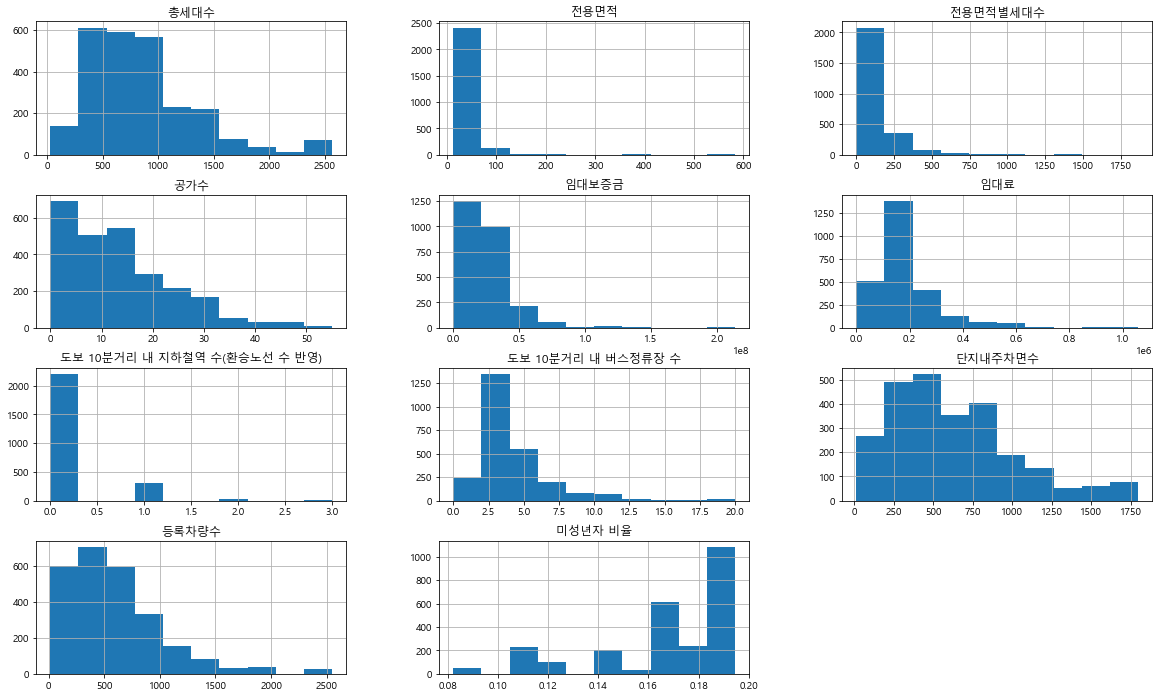

In [73]:
train.hist(figsize=(20,12));

In [74]:
train_mean = train.pivot_table(index='단지코드',aggfunc='mean')
test_mean = test.pivot_table(index='단지코드',aggfunc='mean')
train_mean

,공가수,단지내주차면수,도보 10분거리 내 버스정류장 수,도보 10분거리 내 지하철역 수(환승노선 수 반영),등록차량수,미성년자 비율,임대료,임대보증금,전용면적,전용면적별세대수,총세대수
단지코드,,,,,,,,,,,
C1000,10.0,438.0,1.0,0.0,481.0,0.191395,121064.285714,1.320357e+07,45.218571,80.857143,566
C1004,3.0,153.0,2.0,0.0,93.0,0.184579,118287.186992,1.716798e+07,43.480667,34.466667,521
C1005,16.0,950.0,8.0,0.0,376.0,0.184579,222046.666667,1.710767e+07,54.360000,381.333333,1144
C1013,16.0,1119.0,6.0,0.0,1665.0,0.166665,134726.000000,2.492480e+07,46.142000,261.600000,1308
C1014,5.0,823.0,2.0,0.0,708.0,0.176920,160488.571429,2.389400e+07,49.232857,142.285714,996
...,...,...,...,...,...,...,...,...,...,...,...
C2663,14.0,700.0,3.0,0.0,652.0,0.184072,269070.000000,3.025867e+07,41.005000,128.666667,772
C2666,23.0,837.0,1.0,0.0,701.0,0.113143,133145.000000,1.889050e+07,43.258333,180.666667,1084
C2670,9.0,600.0,2.0,0.0,435.0,0.176920,115188.000000,1.635000e+07,40.918000,129.600000,648


In [75]:
cols = ['임대료', '임대보증금', '전용면적별세대수']

train_agg[cols] = train_mean[cols]
train_agg.head()

,공가수,단지내주차면수,도보 10분거리 내 버스정류장 수,도보 10분거리 내 지하철역 수(환승노선 수 반영),미성년자 비율,총세대수,등록차량수,지역_강원도,지역_경기도,지역_경상남도,...,지역_세종특별자치시,지역_울산광역시,지역_전라남도,지역_전라북도,지역_제주특별자치도,지역_충청남도,지역_충청북도,임대료,임대보증금,전용면적별세대수
단지코드,,,,,,,,,,,,,,,,,,,,,
C2515,17.0,624.0,3.0,0.0,0.163127,545,205.0,0,0,1,...,0,0,0,0,0,0,0,139557.142857,1.678714e+07,77.857143
C2576,19.0,296.0,4.0,0.0,0.163127,405,73.0,0,0,1,...,0,0,0,0,0,0,0,198600.000000,2.384400e+07,202.500000
C2416,0.0,154.0,5.0,0.0,0.163127,560,63.0,0,0,1,...,0,0,0,0,0,0,0,142888.406015,1.785162e+07,56.000000
C2013,3.0,509.0,3.0,0.0,0.163127,595,91.0,0,0,1,...,0,0,0,0,0,0,0,39966.666667,1.514267e+07,198.000000
C1850,0.0,226.0,4.0,0.0,0.163127,388,254.0,0,0,1,...,0,0,0,0,0,0,0,233793.333333,1.348533e+07,128.333333


In [76]:
test_agg[cols] = test_mean[cols]
test_agg.head()

,공가수,단지내주차면수,도보 10분거리 내 버스정류장 수,도보 10분거리 내 지하철역 수(환승노선 수 반영),미성년자 비율,총세대수,지역_강원도,지역_경기도,지역_경상남도,지역_경상북도,...,지역_세종특별자치시,지역_울산광역시,지역_전라남도,지역_전라북도,지역_제주특별자치도,지역_충청남도,지역_충청북도,임대료,임대보증금,전용면적별세대수
단지코드,,,,,,,,,,,,,,,,,,,,,
C1072,14.0,683.0,2.0,0.0,0.184072,754,0,1,0,0,...,0,0,0,0,0,0,0,265843.750000,3.812025e+07,94.250000
C1128,9.0,1216.0,3.0,0.0,0.184072,1354,0,1,0,0,...,0,0,0,0,0,0,0,245516.666667,3.412500e+07,150.444444
C1332,11.0,1112.0,2.0,0.0,0.184072,1297,0,1,0,0,...,0,0,0,0,0,0,0,292880.000000,4.133450e+07,162.125000
C1563,15.0,1696.0,6.0,0.0,0.184072,1974,0,1,0,0,...,0,0,0,0,0,0,0,293214.545455,4.269218e+07,179.454545
C1721,20.0,573.0,3.0,0.0,0.184072,663,0,1,0,0,...,0,0,0,0,0,0,0,263335.000000,3.853050e+07,110.500000


##### 로그 변환

In [77]:
test_agg[cols] = np.log1p(test_agg[cols])
train_agg[cols] = np.log1p(train_agg[cols])


#### 2. 전용 면적
<전용면적> // 연속형?범주형?
```
- 기존 데이터: 소수점 둘째자리까지 존재, unique 개수 656개
- 내림할 경우(int형 변환) unique 개수 64개
==> 내림으로 통일하고 하나씩 컬럼으로 추가
```

In [78]:
train['전용면적'].value_counts()

46.90     196
51.93     118
26.37      43
39.72      40
59.88      33
         ... 
317.17      1
84.91       1
24.75       1
46.16       1
57.87       1
Name: 전용면적, Length: 656, dtype: int64

In [79]:
train['전용면적'].astype(int).value_counts()

46     561
36     346
51     335
39     209
26     189
      ... 
401      1
407      1
61       1
404      1
317      1
Name: 전용면적, Length: 64, dtype: int64

In [80]:
train['전용면적'] = train['전용면적'].astype(int)
test['전용면적'] = test['전용면적'].astype(int)

C:\Users\tladu\AppData\Local\Temp/ipykernel_468/110926138.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['전용면적'] = train['전용면적'].astype(int)


In [ ]:
# (train['전용면적']//10).value_counts()
# train['전용면적'] = (train['전용면적']//5)
# test['전용면적'] = (test['전용면적']//5)

In [81]:
train['전용면적'].value_counts()

46     561
36     346
51     335
39     209
26     189
      ... 
401      1
407      1
61       1
404      1
317      1
Name: 전용면적, Length: 64, dtype: int64

In [82]:
len(test['전용면적'].value_counts())

52

--> 전용면적 int형으로 변환

#### 3. get_dummies + 단지코드로 병합 과정이 필요한 컬럼
'공급_자격유형', '임대건물구분'

In [83]:
def reshape_cat_features(data, cast_col, value_col):
    res = data.drop_duplicates(['단지코드', cast_col]).assign(counter=1).pivot(index='단지코드', columns=cast_col, values=value_col).fillna(0)
    res.columns.name = None
    res = res.rename(columns={col:cast_col+'_'+col for col in res.columns})
    return res

In [84]:
def reshape_cat_features_float(data, cast_col, value_col):
    res = data.drop_duplicates(['단지코드', cast_col]).assign(counter=1).pivot(index='단지코드', columns=cast_col, values=value_col).fillna(0)
    res.columns.name = None
    res = res.rename(columns={col:cast_col+'_'+str(col) for col in res.columns})
    return res

In [85]:
reshape_cat_features(data=train, cast_col='임대건물구분', value_col='counter')

,임대건물구분_상가,임대건물구분_아파트
단지코드,,
C1000,0.0,1.0
C1004,1.0,1.0
C1005,0.0,1.0
C1013,0.0,1.0
C1014,0.0,1.0
...,...,...
C2663,0.0,1.0
C2666,0.0,1.0
C2670,0.0,1.0


In [86]:
reshape_cat_features(data=train, cast_col= '공급_자격유형', value_col='counter')

,공급_자격유형_공공분양_D,공급_자격유형_공공임대(10년)_A,공급_자격유형_공공임대(50년)_A,공급_자격유형_공공임대(5년)_A,공급_자격유형_공공임대(분납)_A,공급_자격유형_국민임대_A,공급_자격유형_국민임대_B,공급_자격유형_국민임대_E,공급_자격유형_국민임대_G,공급_자격유형_국민임대_H,...,공급_자격유형_영구임대_F,공급_자격유형_영구임대_I,공급_자격유형_임대상가_D,공급_자격유형_장기전세_A,공급_자격유형_행복주택_J,공급_자격유형_행복주택_K,공급_자격유형_행복주택_L,공급_자격유형_행복주택_M,공급_자격유형_행복주택_N,공급_자격유형_행복주택_O
단지코드,,,,,,,,,,,,,,,,,,,,,
C1000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C1004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C1005,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C1013,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C1014,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C2663,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C2666,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C2670,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [87]:
reshape_cat_features_float(data=train, cast_col= '전용면적', value_col='counter')

,전용면적_12,전용면적_14,전용면적_15,전용면적_16,전용면적_17,전용면적_18,전용면적_19,전용면적_20,전용면적_21,전용면적_22,...,전용면적_109,전용면적_126,전용면적_137,전용면적_240,전용면적_248,전용면적_317,전용면적_401,전용면적_404,전용면적_407,전용면적_583
단지코드,,,,,,,,,,,,,,,,,,,,,
C1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C1004,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
C1005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C1013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C1014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C2663,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C2666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C2670,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [88]:
train_agg = pd.concat([train_agg,
                       reshape_cat_features(data=train, cast_col='임대건물구분', value_col='counter'),
                       reshape_cat_features(data=train, cast_col= '공급_자격유형', value_col='counter'),
                       reshape_cat_features_float(data=train, cast_col= '전용면적', value_col='counter')
                      ], axis=1)

test_agg = pd.concat([test_agg,
                       reshape_cat_features(data=test, cast_col='임대건물구분', value_col='counter'),
                       reshape_cat_features(data=test, cast_col= '공급_자격유형', value_col='counter'),
                      reshape_cat_features_float(data=test, cast_col= '전용면적', value_col='counter')
                      ], axis=1)

In [89]:
train_agg.head()

,공가수,단지내주차면수,도보 10분거리 내 버스정류장 수,도보 10분거리 내 지하철역 수(환승노선 수 반영),미성년자 비율,총세대수,등록차량수,지역_강원도,지역_경기도,지역_경상남도,...,전용면적_109,전용면적_126,전용면적_137,전용면적_240,전용면적_248,전용면적_317,전용면적_401,전용면적_404,전용면적_407,전용면적_583
단지코드,,,,,,,,,,,,,,,,,,,,,
C2515,17.0,624.0,3.0,0.0,0.163127,545,205.0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C2576,19.0,296.0,4.0,0.0,0.163127,405,73.0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C2416,0.0,154.0,5.0,0.0,0.163127,560,63.0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
C2013,3.0,509.0,3.0,0.0,0.163127,595,91.0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C1850,0.0,226.0,4.0,0.0,0.163127,388,254.0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
test_agg.head()

,공가수,단지내주차면수,도보 10분거리 내 버스정류장 수,도보 10분거리 내 지하철역 수(환승노선 수 반영),미성년자 비율,총세대수,지역_강원도,지역_경기도,지역_경상남도,지역_경상북도,...,전용면적_74,전용면적_75,전용면적_82,전용면적_84,전용면적_240,전용면적_248,전용면적_253,전용면적_401,전용면적_404,전용면적_583
단지코드,,,,,,,,,,,,,,,,,,,,,
C1072,14.0,683.0,2.0,0.0,0.184072,754,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C1128,9.0,1216.0,3.0,0.0,0.184072,1354,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C1332,11.0,1112.0,2.0,0.0,0.184072,1297,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C1563,15.0,1696.0,6.0,0.0,0.184072,1974,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C1721,20.0,573.0,3.0,0.0,0.184072,663,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 3) 모델 학습

In [95]:
from sklearn.model_selection import train_test_split

X = train_agg.drop(['등록차량수'],axis=1)
y = train_agg['등록차량수']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [97]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)
xgb_model.score(X_test, y_test)

0.7556349683358403

In [94]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
rf_model.score(X_test, y_test)

0.7685316806524103